In [1]:
import random

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BDeuScore
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling

from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Create original network for comparison

In [2]:
base_model = BayesianNetwork([('Smoking', 'Lung_Cancer'),
                            ('Genetics', 'Lung_Cancer'),
                            ('Genetics', 'Attention_Disorder'),
                            ('Smoking', 'Yellow_Fingers'),
                            ('Anxiety', 'Smoking'),
                            ('Peer_Pressure', 'Smoking'),
                            ('Allergy', 'Coughing'),
                            ('Lung_Cancer', 'Coughing'),
                            ('Coughing', 'Fatigue'),
                            ('Lung_Cancer', 'Fatigue'),
                            ('Fatigue', 'Car_Accident'),
                            ('Attention_Disorder', 'Car_Accident')])

base_model.add_node("Born_an_Even_Day")

In [3]:
base_model.nodes()

NodeView(('Smoking', 'Lung_Cancer', 'Genetics', 'Attention_Disorder', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Allergy', 'Coughing', 'Fatigue', 'Car_Accident', 'Born_an_Even_Day'))

In [4]:
Anxiety_CPD = TabularCPD(variable='Anxiety', variable_card=2, values=[[1-0.64277], [0.64277]])

Peer_Pressure_CPD = TabularCPD(variable='Peer_Pressure', variable_card=2, values=[[1-0.32997], [0.32997]])

Genetics_CPD = TabularCPD(variable='Genetics', variable_card=2, values=[[1-0.15953], [0.15953]])

Born_an_Even_Day_CPD = TabularCPD(variable='Born_an_Even_Day', variable_card=2, values=[[1-0.5], [0.5]])

Allergy_CPD = TabularCPD(variable='Allergy', variable_card=2, values=[[1-0.32841], [0.32841]])

Yellow_Fingers_CPD = TabularCPD(variable='Yellow_Fingers', variable_card=2,
                                values=[[1-0.23119, 1-0.95372],
                                        [  0.23119,   0.95372]],
                                evidence=['Smoking'],
                                evidence_card=[2])

Attention_Disorder_CPD = TabularCPD(variable='Attention_Disorder', variable_card=2,
                                values=[[1-0.28956, 1-0.68706],
                                        [  0.28956,   0.68706]],
                                evidence=['Genetics'],
                                evidence_card=[2])

Smoking_CPD = TabularCPD(variable='Smoking', variable_card=2, 
                         values=[[1-0.43118, 1-0.74591, 1-0.8686, 1-0.91576],
                                 [  0.43118,   0.74591,   0.8686,   0.91576]],
                         evidence=['Anxiety', 'Peer_Pressure'],
                         evidence_card=[2, 2])

Lung_Cancer_CPD = TabularCPD(variable='Lung_Cancer', variable_card=2, 
                             values=[[1-0.23146, 1-0.83934, 1-0.86996, 1-0.99351],
                                     [  0.23146,   0.83934,   0.86996,   0.99351]],
                             evidence=['Genetics', 'Smoking'],
                             evidence_card=[2, 2])

Coughing_CPD = TabularCPD(variable='Coughing', variable_card=2, 
                          values=[[1-0.1347, 1-0.7664, 1-0.64592, 1-0.99947],
                                  [  0.1347,   0.7664,   0.64592,   0.99947]],
                          evidence=['Allergy', 'Lung_Cancer'],
                          evidence_card=[2, 2])

Fatigue_CPD = TabularCPD(variable='Fatigue', variable_card=2, 
                          values=[[1-0.35212, 1-0.80016, 1-0.56514, 1-0.89589],
                                  [  0.35212,   0.80016,   0.56514,   0.89589]],
                          evidence=['Lung_Cancer', 'Coughing'],
                          evidence_card=[2, 2])

Car_Accident_CPD = TabularCPD(variable='Car_Accident', variable_card=2, 
                          values=[[1-0.2274, 1-0.78861 , 1-0.779, 1-0.97169],
                                  [  0.2274,   0.78861 ,   0.779,   0.97169]],
                          evidence=['Attention_Disorder', 'Fatigue'],
                          evidence_card=[2, 2])

In [5]:
base_model.add_cpds(Anxiety_CPD, Peer_Pressure_CPD, Smoking_CPD, Yellow_Fingers_CPD, Genetics_CPD, 
                    Born_an_Even_Day_CPD, Allergy_CPD, Lung_Cancer_CPD, Coughing_CPD, Fatigue_CPD,
                    Car_Accident_CPD, Attention_Disorder_CPD)

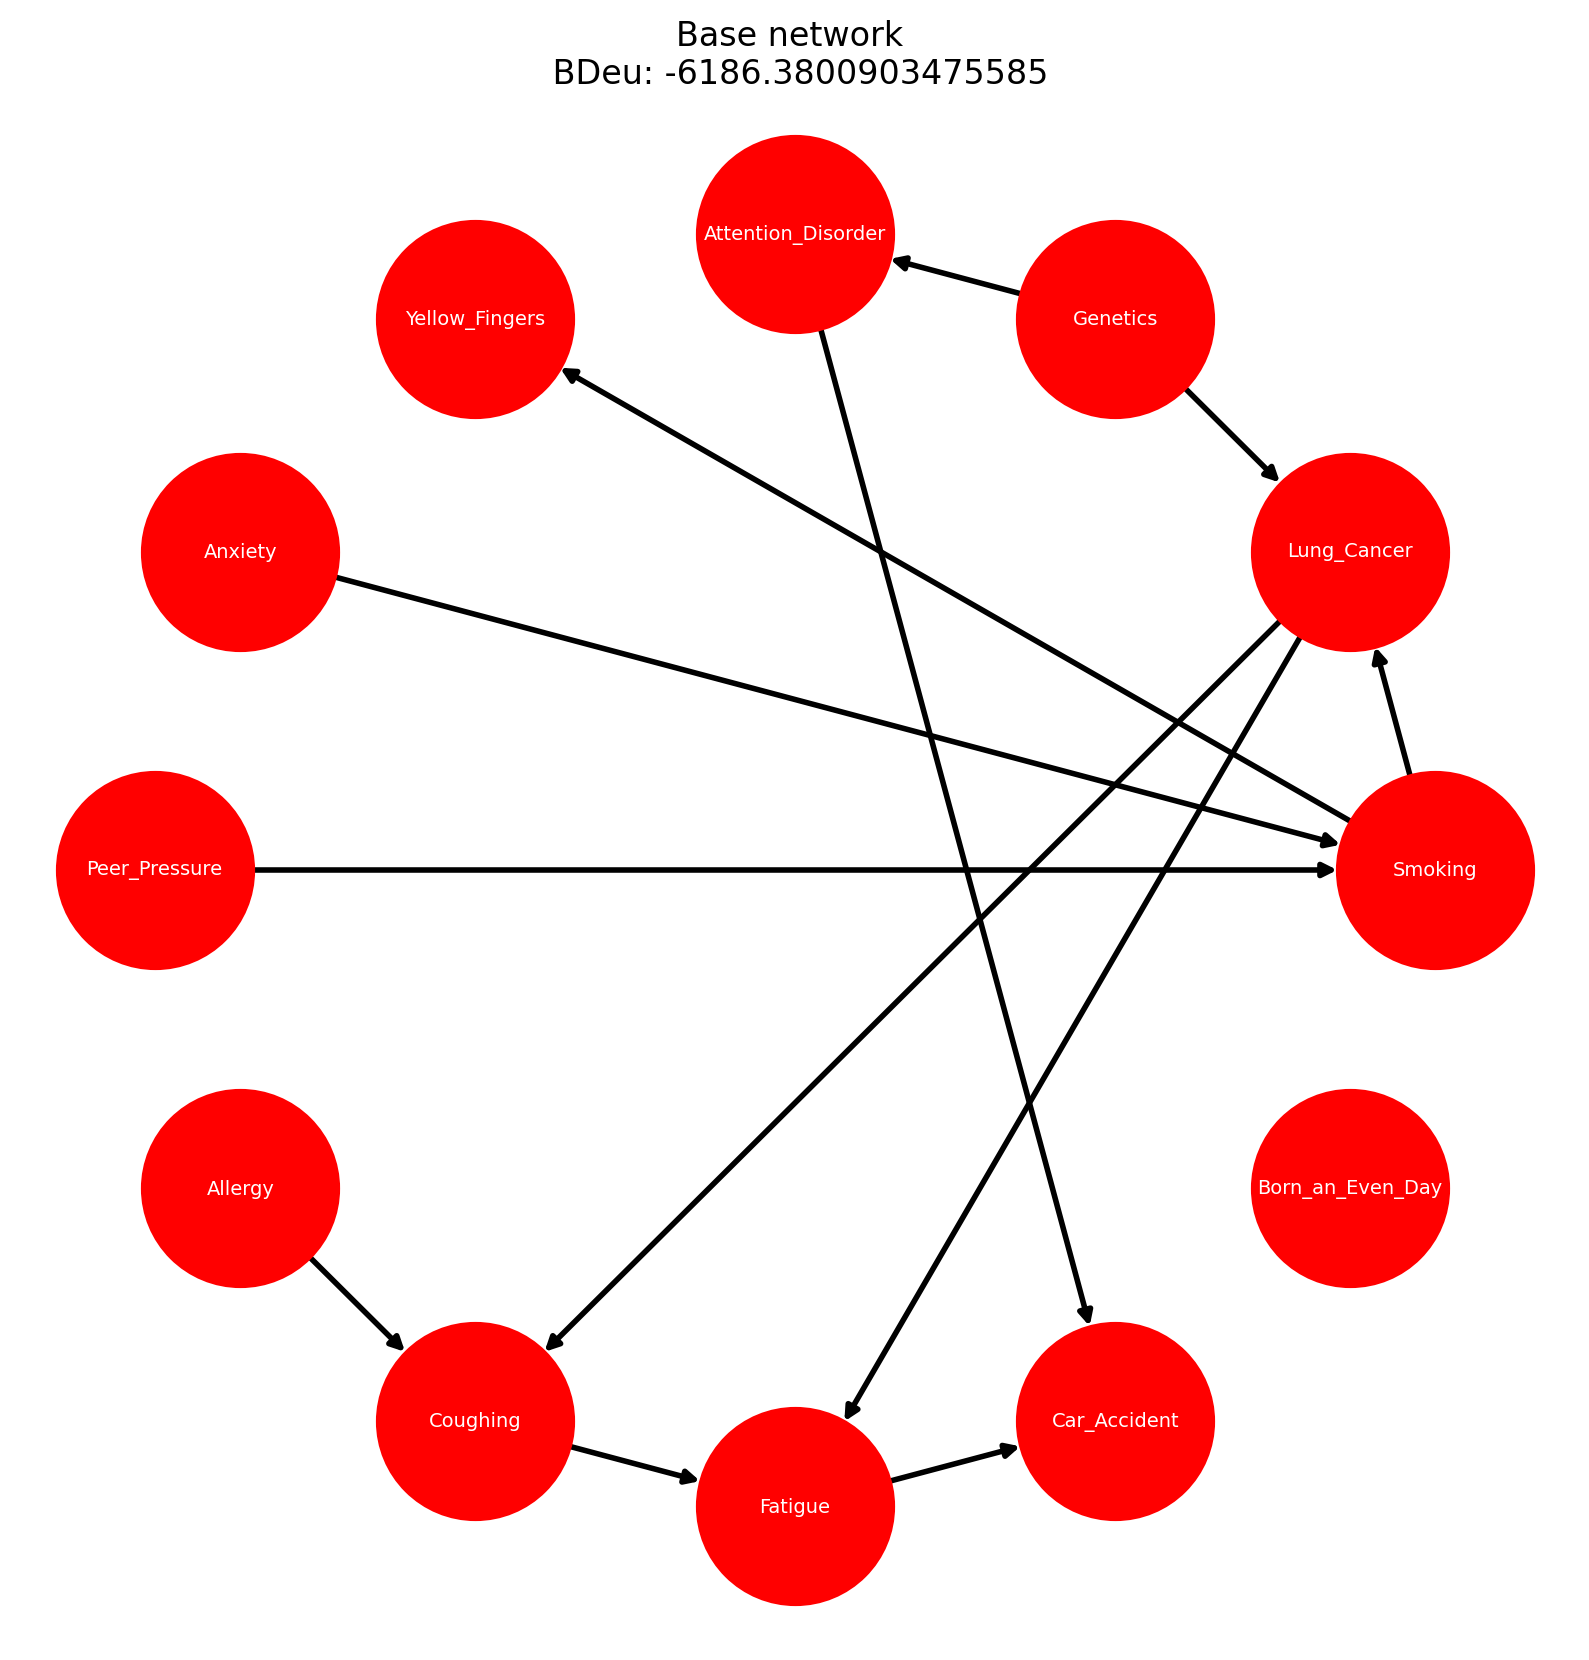

In [7]:
bdeu = BDeuScore(pd.read_csv('./lucas0.csv'), equivalent_sample_size=5)

digraph = nx.DiGraph()
digraph.add_nodes_from(base_model.nodes())

codes = list()
for edge in base_model.edges():
    digraph.add_edge(edge[0], edge[1], color="black", style='-')

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_title("Base network \n BDeu: "+ str(bdeu.score(base_model)))

edges_names = digraph.edges()
colors = [digraph[u][v]['color'] for u,v in edges_names]

# Custom the nodes:
nx.draw(digraph, with_labels=True, node_color='red', font_color='white', font_size=7, node_size=5000, 
        width=2.0, pos=nx.circular_layout(digraph), edge_color=colors, ax=ax)

In [21]:
generated_samples = base_model.simulate(1000)

  0%|          | 0/12 [00:00<?, ?it/s]

In [22]:
generated_samples.to_csv('lucas0_1000.csv', index=False)